In [1]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split


/home/albert/ai/ASL_Classifier/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data processing

data_dir = "./data"
train_dir = "/asl_alphabet_train/asl_alphabet_train"
classes = os.listdir(data_dir + train_dir)


# Set transform
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(data_dir + train_dir, transform)

image, label = dataset[0]

print(dataset.classes)




['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [3]:
def show_image(image, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow((image.permute(1, 2, 0)))

In [4]:
# Test Train Split

print(len(dataset))

validation_size = 7000
test_size = 14000

train_size = len(dataset) - validation_size - test_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))



87000
66000 7000 14000


Label:  A (0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


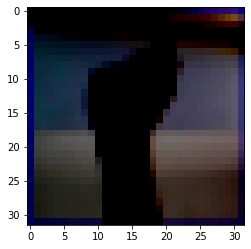

In [5]:
show_image(*dataset[0])


In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [7]:
# Create dataloaders

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [8]:
# Initialize device
device = get_device()
print(device)
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

cuda


In [9]:
def accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

In [10]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [12]:
model = ResNet(3, 29)
model.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [13]:
@torch.no_grad()
def evaluate(model, validation_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(validation_loader)]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
history = [evaluate(model, validation_dataloader)]
history

100%|██████████| 110/110 [00:05<00:00, 21.00it/s]


[{'val_loss': 3.368450880050659, 'val_acc': 0.02708333358168602}]

In [15]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [16]:
history += fit_one_cycle(
    epochs,
    max_lr,
    model,
    train_dataloader,
    validation_dataloader, 
    grad_clip=grad_clip, 
    weight_decay=weight_decay, 
    opt_func=opt_func
)

100%|██████████| 110/110 [00:03<00:00, 35.76it/s]


Epoch [0], last_lr: 0.00152, train_loss: 0.2769, val_loss: 0.3033, val_acc: 0.8983


100%|██████████| 110/110 [00:08<00:00, 13.69it/s]


Epoch [1], last_lr: 0.00436, train_loss: 0.1079, val_loss: 0.1157, val_acc: 0.9628


100%|██████████| 110/110 [00:02<00:00, 40.39it/s]


Epoch [2], last_lr: 0.00760, train_loss: 0.1104, val_loss: 0.1159, val_acc: 0.9605


100%|██████████| 110/110 [00:02<00:00, 41.62it/s]


Epoch [3], last_lr: 0.00971, train_loss: 0.0709, val_loss: 0.3148, val_acc: 0.9049


100%|██████████| 110/110 [00:02<00:00, 41.20it/s]


Epoch [4], last_lr: 0.00994, train_loss: 0.0725, val_loss: 0.1087, val_acc: 0.9626


100%|██████████| 110/110 [00:02<00:00, 40.17it/s]


Epoch [5], last_lr: 0.00950, train_loss: 0.0588, val_loss: 0.0211, val_acc: 0.9935


100%|██████████| 110/110 [00:02<00:00, 42.21it/s]


Epoch [6], last_lr: 0.00867, train_loss: 0.0479, val_loss: 0.0234, val_acc: 0.9936


100%|██████████| 110/110 [00:02<00:00, 42.40it/s]


Epoch [7], last_lr: 0.00750, train_loss: 0.0325, val_loss: 0.0637, val_acc: 0.9835


100%|██████████| 110/110 [00:02<00:00, 42.14it/s]


Epoch [8], last_lr: 0.00611, train_loss: 0.0245, val_loss: 0.0065, val_acc: 0.9986


100%|██████████| 110/110 [00:02<00:00, 41.32it/s]


Epoch [9], last_lr: 0.00463, train_loss: 0.0153, val_loss: 0.0154, val_acc: 0.9946


100%|██████████| 110/110 [00:04<00:00, 25.49it/s]


Epoch [10], last_lr: 0.00317, train_loss: 0.0089, val_loss: 0.0033, val_acc: 0.9993


100%|██████████| 110/110 [00:02<00:00, 40.37it/s]


Epoch [11], last_lr: 0.00188, train_loss: 0.0026, val_loss: 0.0015, val_acc: 0.9999


100%|██████████| 110/110 [00:02<00:00, 41.24it/s]


Epoch [12], last_lr: 0.00087, train_loss: 0.0004, val_loss: 0.0003, val_acc: 1.0000


100%|██████████| 110/110 [00:02<00:00, 41.72it/s]


Epoch [13], last_lr: 0.00022, train_loss: 0.0002, val_loss: 0.0002, val_acc: 1.0000


100%|██████████| 110/110 [00:03<00:00, 29.33it/s]


Epoch [14], last_lr: 0.00000, train_loss: 0.0002, val_loss: 0.0002, val_acc: 1.0000


In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

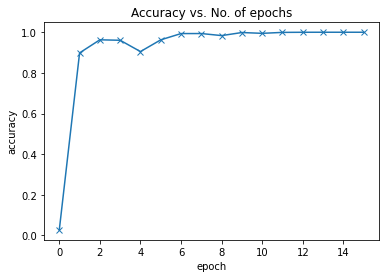

In [18]:
plot_accuracies(history)

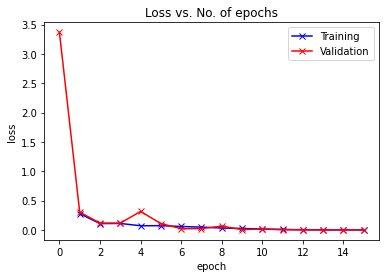

In [19]:
plot_losses(history)

In [20]:
torch.save(model.state_dict(), 'resnet.pth')

In [21]:
# Evaluate saved model
model = ResNet(3, 29)
model.to(device)

model.load_state_dict(torch.load('resnet.pth'))
model.eval()

evaluate(model, test_dataloader)

100%|██████████| 219/219 [00:05<00:00, 40.16it/s]


{'val_loss': 0.00036743335658684373, 'val_acc': 1.0}

In [22]:
def predict_single(input, target, model):
    predictions = model(input)
    _, preds = torch.max(predictions, dim=1)
    
    print("Target:", target)
    print("Prediction:", preds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  H (tensor(7))
Target: tensor(7, device='cuda:0')
Prediction: tensor([7], device='cuda:0')


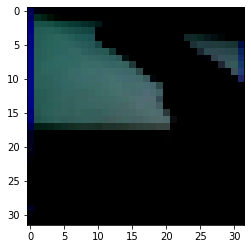

In [23]:
for input, label in test_dataloader:
    show_image(input[0].cpu(), label[0].cpu())
    predict_single(input[0].view(1, 3, 32, 32), label[0], model)
    break

In [24]:
torch.save(model.state_dict(), 'resnet.pth')
